In [1]:
import requests
from bs4 import BeautifulSoup
import pandas
import matplotlib
import numpy
import math
import seaborn
# Doc: https://www.parlament.ch/fr/ratsbetrieb/suche-curia-vista/geschaeft?AffairId=19993636


In [2]:

source_page_url = 'https://www.bfs.admin.ch/bfs/fr/home/statistiques/catalogues-banques-donnees.assetdetail.je-d-01.02.03.02.html'

page = requests.get(source_page_url)
soup = BeautifulSoup(page.text, 'html.parser')
 
urls = []
targets = soup.find_all('a', href=True, class_="icon--excel")
target_data_url = targets[0].get('href')

sheet_names = [str(year) for  year in range(2010, 2022)]

raw_data = pandas.read_excel(target_data_url, sheet_name=sheet_names)
demography = dict()
for year_str in raw_data:
  year = int(year_str)
  columns = raw_data[year_str].iloc[0].tolist()
  demography[year] = raw_data[year_str].iloc[2:].iloc[:106]
  demography[year].columns = columns
  demography[year] = demography[year][['Alter', 'Total']]
  demography[year].set_index('Alter', inplace=True)

distribution = pandas.concat(demography.values(), axis=1)
distribution.columns = demography.keys()

# Insurance premia global average, according  to https://www.bag.admin.ch/bag/fr/home/zahlen-und-statistiken/statistiken-zur-krankenversicherung/statistik-der-obligatorischen-krankenversicherung.html
# Data T 1.01
premia = pandas.Series(data={
  2010: 2834,
  2011: 3005,
  2012: 3075,
  2013: 3105,
  2014: 3172,
  2015: 3289,
  2016: 3442,
  2017: 3605,
  2018: 3735,
  2019: 3772,
  2020: 3777,
  2021: 3788
})

/home/codespace/.python/current/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/home/codespace/.python/current/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/home/codespace/.python/current/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/home/codespace/.python/current/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/home/codespace/.python/current/lib/python3.10/site-packages/openpyxl/wo

/home/codespace/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:47: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  result = wrap(result)


<Axes: xlabel='Alter'>

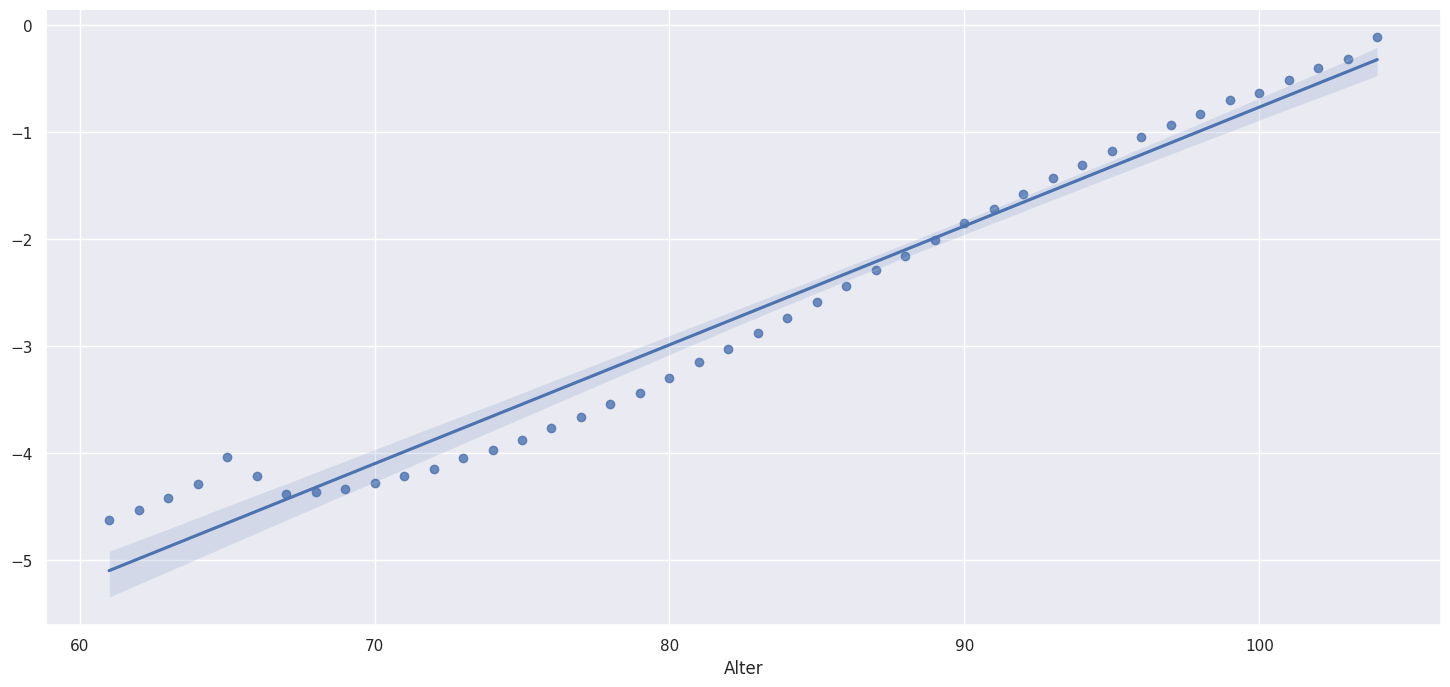

In [3]:
# TODO
# estimate distribution for year N given data up to N-1
# year N = shift (year N-1) - deaths a year N
# deaths at year N are estimated using death rates as an average 
# over years 1..N-1
# "deaths" are actually simply the change in population from one range to the 
# next from one year to the next (ignores migrations in and out)
#

def estimate_deaths(year: int, population: pandas.DataFrame):
  up_to_year = population[(column for column in population.columns if column < year)]
  estimated_deaths = pandas.DataFrame(data=up_to_year.iloc[:-1][(up_to_year.columns[:-1])].to_numpy() - up_to_year.iloc[1:][(up_to_year.columns[1:])].to_numpy())
  estimated_deaths.columns = up_to_year.columns[1:]
  estimated_deaths.index = up_to_year[1:].index
  return estimated_deaths.iloc[:-1].iloc[60:]

death_rates = estimate_deaths(2022, distribution).divide(distribution).dropna(how='all', axis=0).dropna(how='all', axis=1).mean(axis=1)
seaborn.set(rc={'figure.figsize':(18, 8)})
seaborn.regplot(x=death_rates.index, y=numpy.log(death_rates.values))

<Axes: xlabel='Alter'>

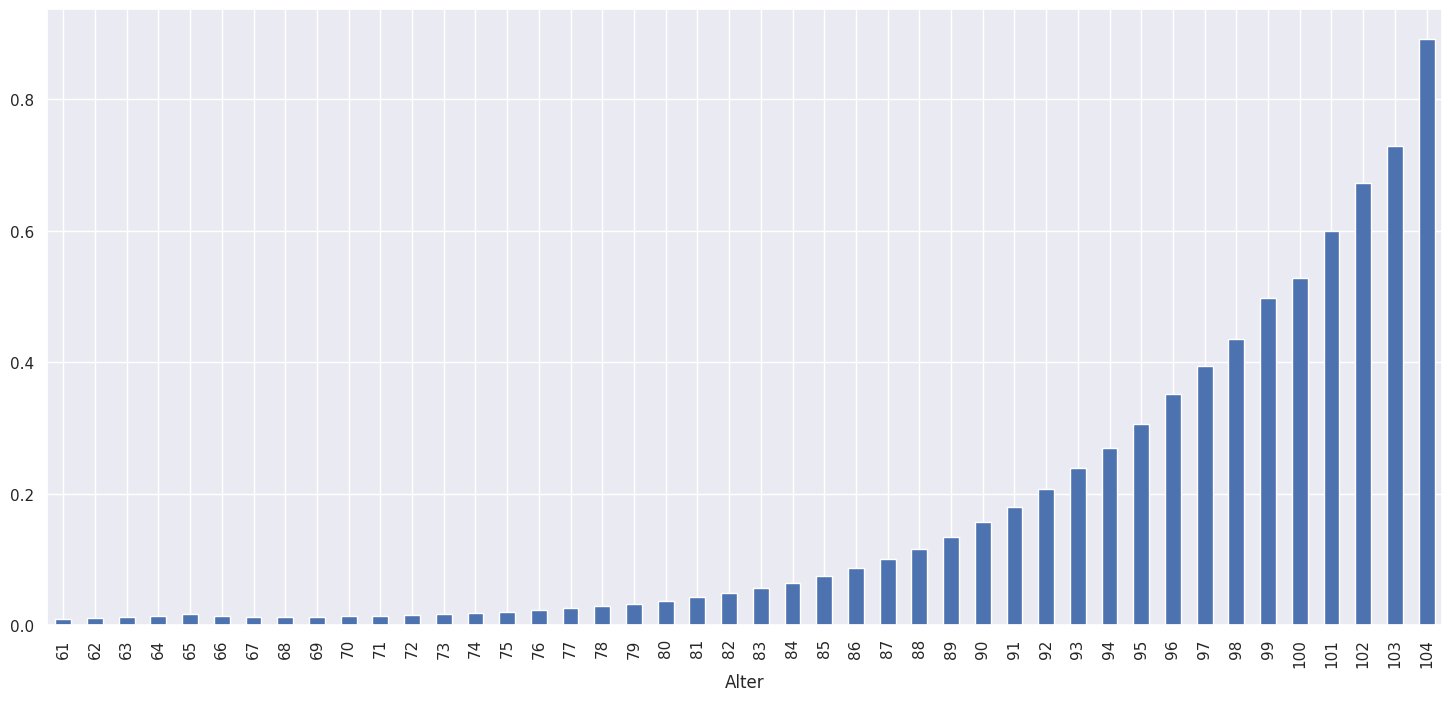

In [4]:
death_rates.plot(kind='bar')

<Axes: xlabel='Alter'>

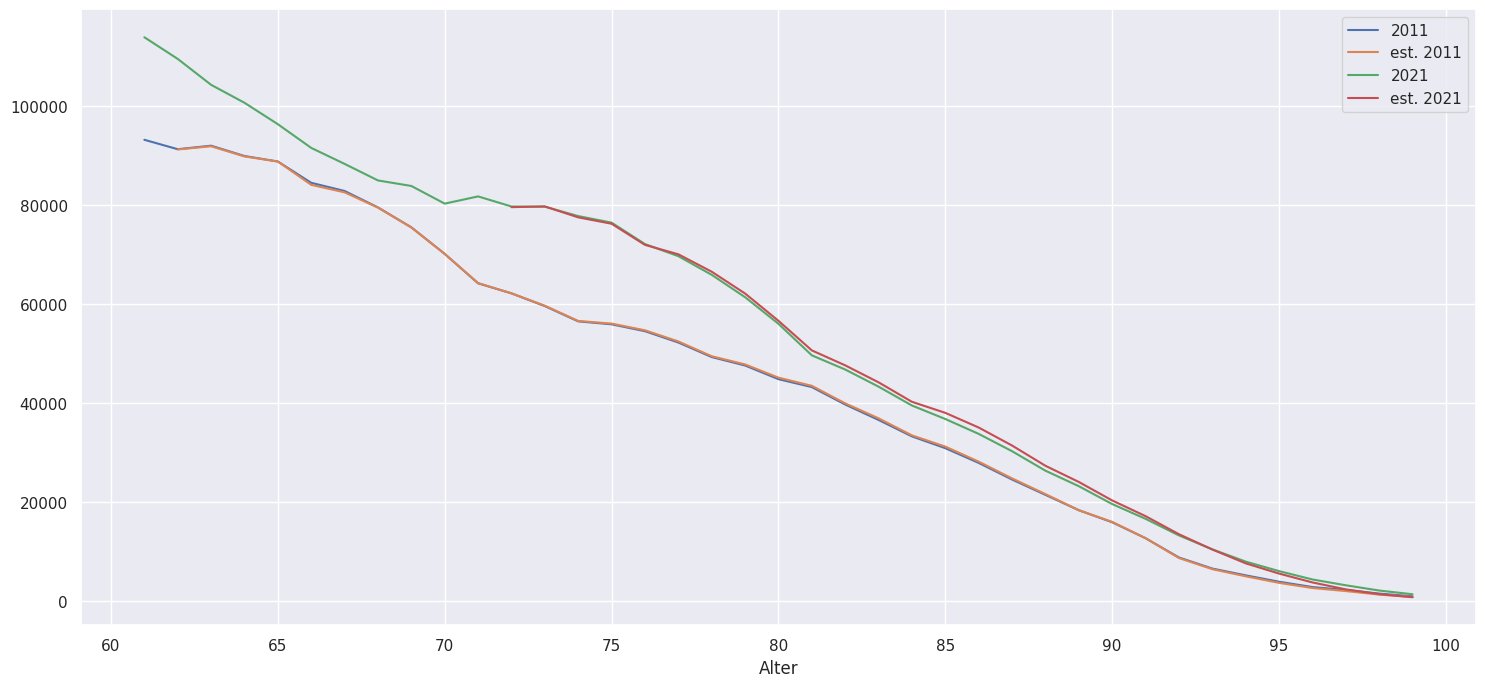

In [5]:
ref_year = 2010
back_projection = distribution.iloc[61:100][[ref_year]].reset_index()
back_projection['est. {}'.format(ref_year + 1)] = back_projection[ref_year].sub(back_projection['Alter'].apply(lambda age: death_rates[age]).mul(back_projection[ref_year])).astype(int).shift()
for year in range(ref_year + 2, ref_year + 12):
  back_projection['est. {}'.format(year)] = back_projection['est. {}'.format(year - 1)].sub(back_projection['Alter'].apply(lambda age: death_rates[age]).mul(back_projection['est. {}'.format(year - 1)])).shift()
  
back_projection.set_index('Alter', inplace=True)
for year in range(ref_year + 1, ref_year + 12):
  back_projection[year] = distribution[year]
  
back_projection[[ref_year + 1, 'est. {}'.format(ref_year + 1), ref_year + 11, 'est. {}'.format(ref_year + 11)]].plot()


<Axes: xlabel='Alter'>

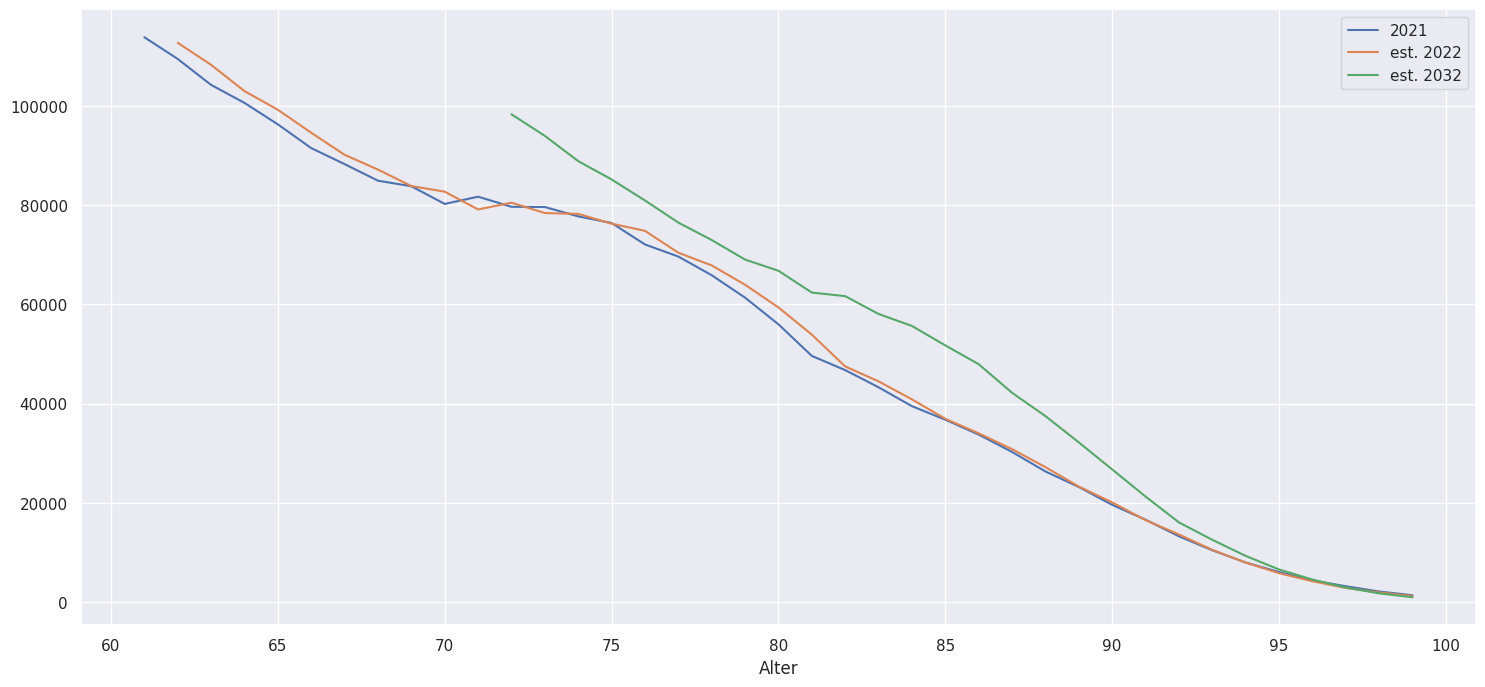

In [6]:
ref_year = 2021
projection = distribution.iloc[61:100][[ref_year]].reset_index()
projection['est. {}'.format(ref_year + 1)] = projection[ref_year].sub(projection['Alter'].apply(lambda age: death_rates[age]).mul(projection[ref_year])).astype(int).shift()
for year in range(ref_year + 2, ref_year + 12):
  projection['est. {}'.format(year)] = projection['est. {}'.format(year - 1)].sub(projection['Alter'].apply(lambda age: death_rates[age]).mul(projection['est. {}'.format(year - 1)])).shift()
  
projection.set_index('Alter', inplace=True)
projection[[ref_year, 'est. {}'.format(ref_year + 1), 'est. {}'.format(ref_year + 11)]].plot()

<Axes: >

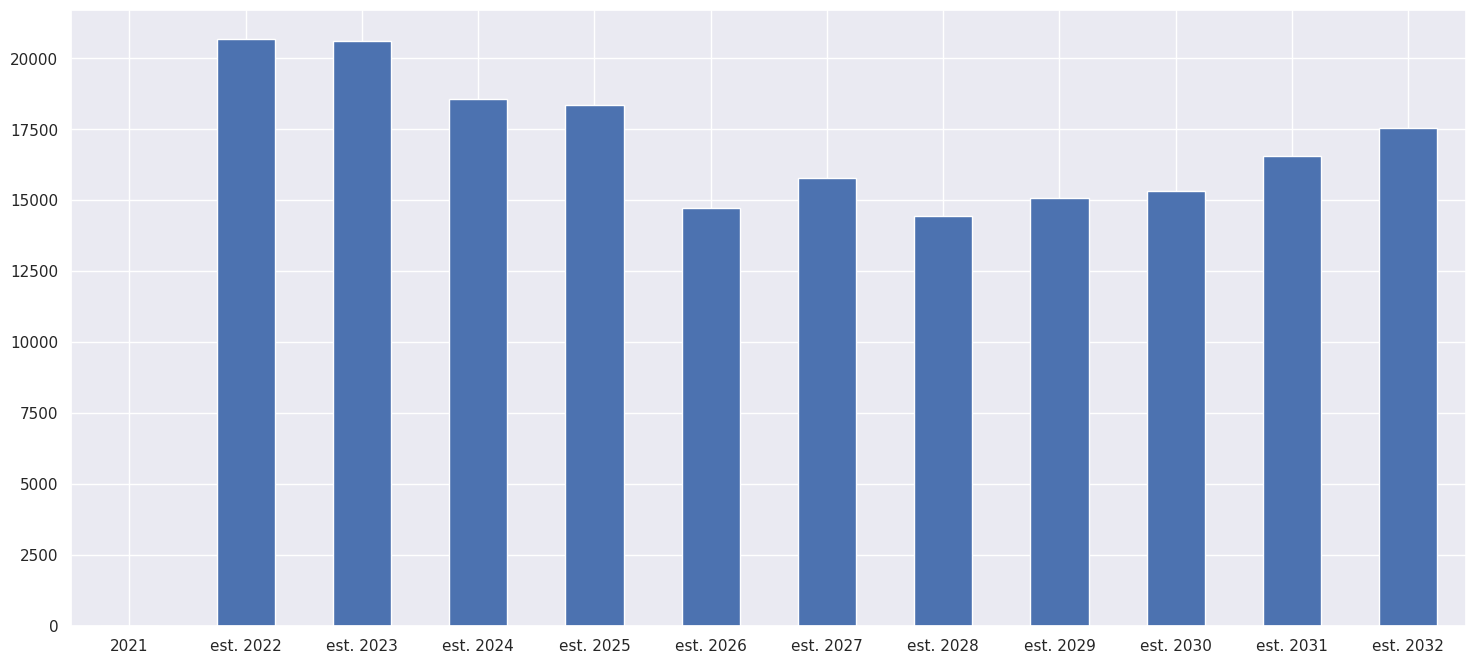

In [7]:
matplotlib.pyplot.ticklabel_format(style='plain', axis='y')
projection.loc[75:].sum().astype(int).diff().plot(kind='bar', rot=0)

<Axes: >

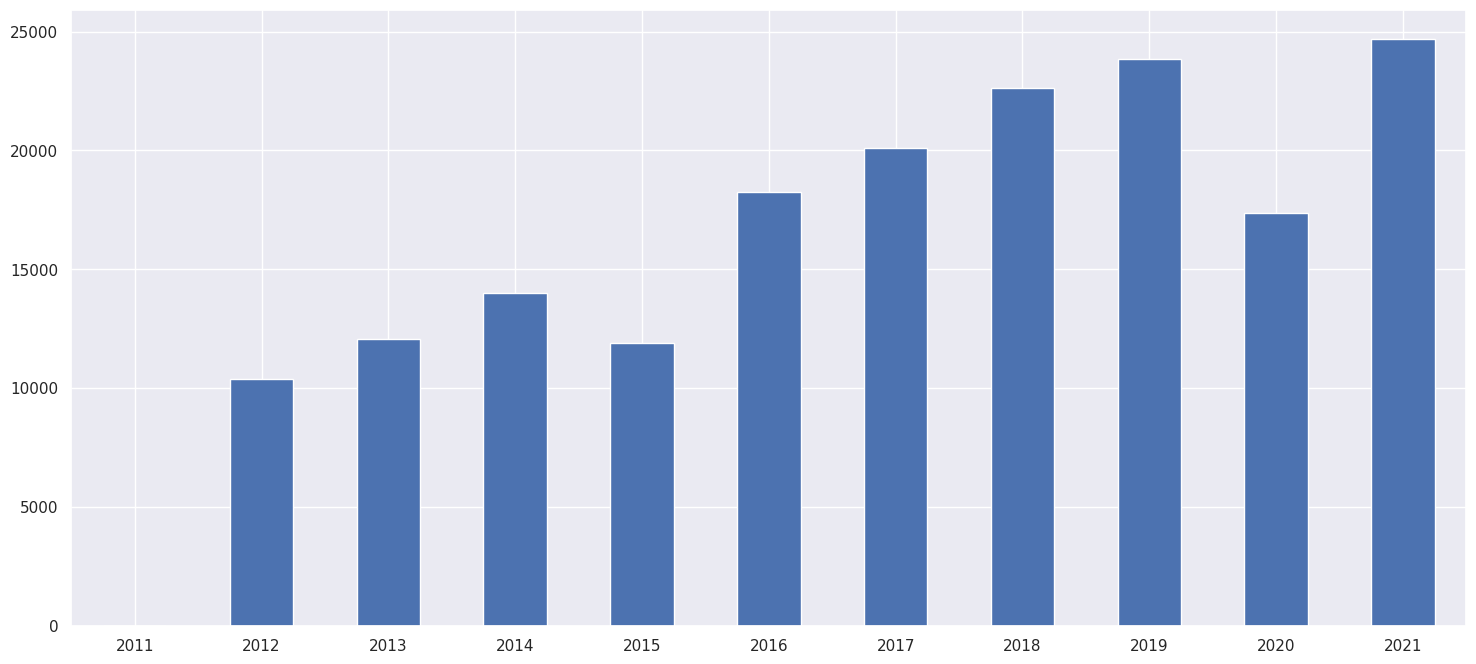

In [8]:
back_projection.loc[75:].sum().astype(int)[range(2011, 2022)].diff().plot(kind='bar', rot=0)